In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
FIG_PREFIX = 'webpage'

In [3]:
root_dir = '../result/dblp_small_1000_result'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [34]:
def build_stats_filename(row):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    return '_'.join(fields)

In [26]:
def get_stats_df(row):
    fname = build_stats_filename(row)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t')

In [27]:
summary_path = os.path.join(root_dir, 'summary.csv')
summary_df = pd.read_csv(summary_path)

In [28]:
summary_df.ffill(inplace=True)
summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']

In [29]:
# code for getting end-to-end trimmed mean
res = summary_df.sort_values('overall_time')

In [30]:
gb = res.groupby(by=id_cols)
if gb.count()['selection_time'].min() > 2:
    res = res.drop(gb.tail(1).index)
    res = res.drop(gb.head(1).index)

In [31]:
res_df = res.groupby(by=id_cols, as_index=False).mean(numeric_only=True).apply(lambda x: x)

In [32]:
def add_num_after_filter(df):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': []
    }
    
    for _, row in df.iterrows():
        detail_df = get_stats_df(row)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        # if detail_df['count'].sum() != 368166:
        # print(build_stats_filename(row))
        # print(detail_df)
    return df.assign(**new_cols)

In [35]:
res_df = add_num_after_filter(res_df)
res_df.describe()

,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count
count,99.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.000000,99.000000
mean,16.0,8.696970,0.166667,7882.949495,1729.370670,3.532997,1732.924498,7.630879e+07,0.185204,133.851149,134.036353,1866.960851,1.656536e+07,16565.357889,913840.929293
std,0.0,4.851792,0.265453,10779.584164,11804.841410,1.582856,11804.333660,1.984175e+07,0.251102,94.567083,94.566464,11853.915292,4.321277e+07,43212.773277,0.703526
min,16.0,-1.000000,-1.000000,420.000000,2.508400,-1.000000,3.537680,4.176000e+04,0.017165,53.941849,54.053279,62.439628,1.708837e+06,1708.837000,913834.000000
25%,16.0,4.000000,0.030000,1363.000000,3.146175,2.720860,5.946430,7.535445e+07,0.041634,97.365995,97.437903,107.053691,2.141256e+06,2141.256000,913841.000000
50%,16.0,8.000000,0.100000,2663.000000,4.822260,3.352460,8.163760,8.306945e+07,0.076887,117.201964,117.273694,128.505660,3.789202e+06,3789.202000,913841.000000
75%,16.0,12.000000,0.250000,9004.000000,7.790050,4.361325,12.504650,8.629923e+07,0.235019,134.708493,134.958780,146.834355,5.091482e+06,5091.482000,913841.000000
max,16.0,16.000000,0.700000,41321.000000,92697.700000,7.978360,92697.900000,9.086285e+07,1.388873,862.167524,862.241069,92874.795382,2.391366e+08,239136.631000,913841.000000


In [36]:
res_df.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count'],
      dtype='object')

In [38]:
res_df

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count
0,BEST,16,-1,0.50,420,92697.70000,0.137696,92697.90000,41760.0,0.045425,176.849957,176.895382,92874.795382,3410306,3410.306,913834
1,FAST,16,-1,-1.00,437,73046.00000,-1.000000,73046.00000,66544.0,0.073545,862.167524,862.241069,73908.241069,239136631,239136.631,913841
2,FAST,16,-1,-1.00,929,4920.91000,-1.000000,4920.91000,41498628.0,0.057532,110.228234,110.285766,5031.195766,239136631,239136.631,913841
3,FREE-parallel,16,2,0.01,1655,2.72305,0.821172,3.54422,5552164.0,0.017240,482.044212,482.061452,485.605672,210438711,210438.711,913841
4,FREE-parallel,16,2,0.02,1690,2.50840,1.029280,3.53768,10278096.0,0.017952,383.918055,383.936007,387.473687,153291882,153291.882,913841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,FREE-parallel,16,16,0.15,2663,4.30219,3.415710,7.71790,83069446.0,0.081592,112.045372,112.126964,119.844864,1744319,1744.319,913841
95,FREE-parallel,16,16,0.20,2011,3.69494,3.279100,6.97404,81752484.0,0.071922,130.435105,130.507027,137.481067,2141256,2141.256,913841
96,FREE-parallel,16,16,0.30,1363,2.96709,2.632180,5.59927,79599214.0,0.023773,82.832022,82.855795,88.455065,3727367,3727.367,913841
97,FREE-parallel,16,16,0.50,810,2.80156,2.456890,5.25845,75354446.0,0.030932,123.216278,123.247210,128.505660,4171619,4171.619,913841


In [ ]:
# explore the distribution of number of keys and number

[2. 4. 6.]


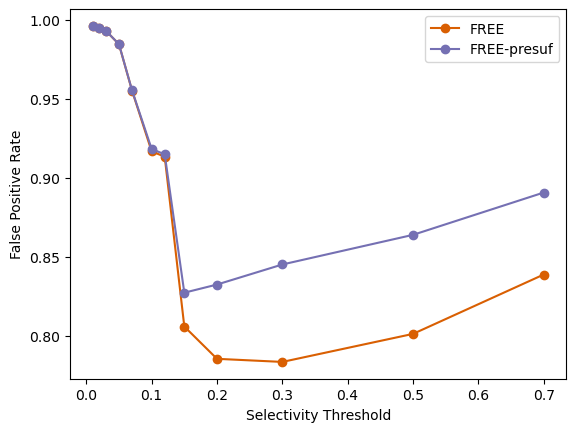

In [13]:
# gram size vs accuracy
temp_g = res_df[res_df['num_threads'] == 1]
colors = ['#1b9e77','#d95f02','#7570b3']
# for i, name in enumerate(['BEST', 'FREE']):
#     ax = plt.subplot()
#     temp = temp_g[temp_g['name'].str.contains(name)]
#     x = temp['selectivity']
#     y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
#     x, y = zip(*sorted(zip(x, y)))
#     print(temp)
#     ax.plot(x, y, label=name, c=colors[i]) 
#     plt.xlabel('Max Gram Size')
#     plt.ylabel('False Positive Rate')
#     plt.legend()
#     plt.savefig(f'figs/{FIG_PREFIX}_sel_false_positive.pdf', bbox_inches='tight')

#     plt.show()

# # BEST
# ax = plt.subplot()
# temp = temp_g[temp_g['name'].str.contains('BEST')]
# x = temp['selectivity']
# y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
# # x, y = zip(*sorted(zip(x, y)))
# # print(temp)
# ax.plot(x, y, marker='o', label='BEST', c=colors[0]) 
# plt.xlabel('Selectivity Threshold')
# plt.ylabel('False Positive Rate')
# plt.legend()
# plt.savefig(f'figs/{FIG_PREFIX}_best_sel_vs_fp.pdf', bbox_inches='tight')
# plt.show()

print(temp_g['gram_size'].unique())

# FREE
ax = plt.subplot()
temp = temp_g[(temp_g['name'] == ('FREE')) & (temp_g['gram_size'] == 2)]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y, marker='o', label='FREE', c=colors[1]) 

temp = temp_g[(temp_g['name'].str.contains('FREE-presuf')) & (temp_g['gram_size'] == 2)]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y, marker='o', label='FREE-presuf', c=colors[2]) 

plt.xlabel('Selectivity Threshold')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_free_sel_vs_fp.pdf', bbox_inches='tight')
plt.show()

In [14]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [15]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [16]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

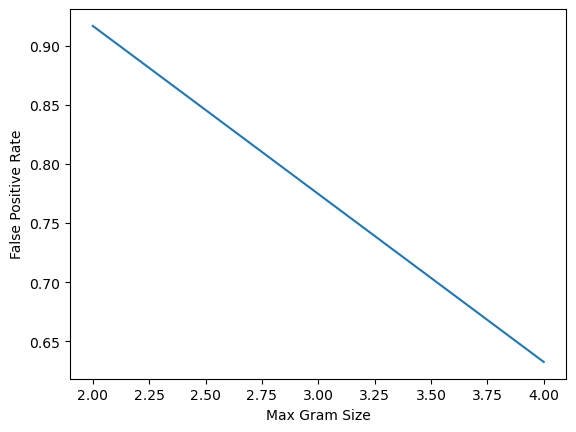

In [17]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

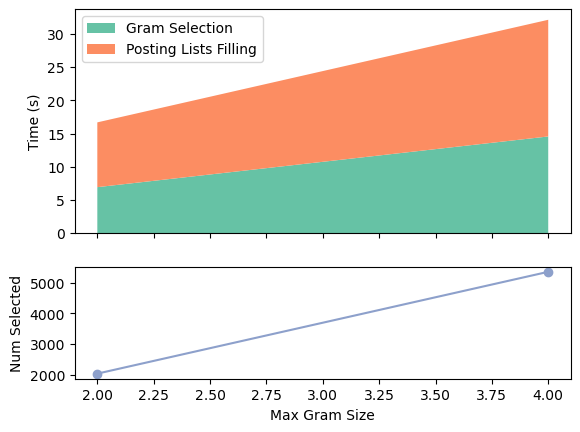

In [18]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

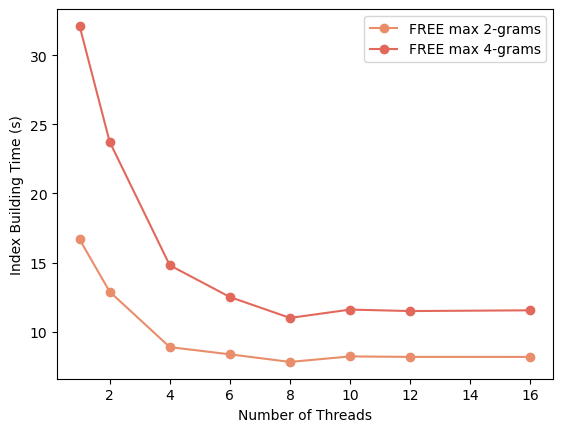

In [19]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

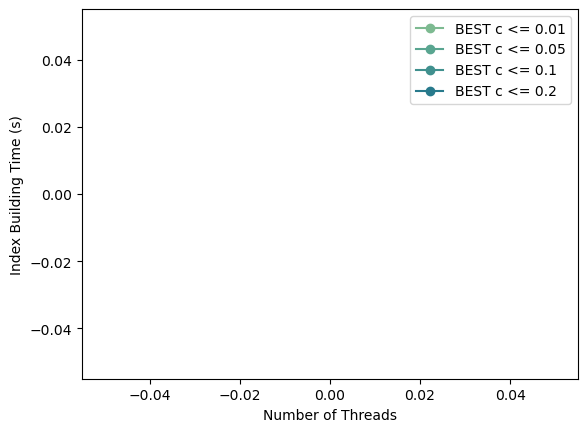

In [20]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()